In [ ]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install Levenshtein
!pip install geocoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Downloading all bonds ever owned in CSPP

In [ ]:
import requests, datetime

In [ ]:
# This function gets the csv from the url and places the new data in a dictionary with keys = ISIN,
# and value = [NCB, ISSUER, MATURITY DATE, COUPON RATE]
def downloadDataToDictionary(url,dictionary):
    r = requests.get(url) # create HTTP response object
    nameCompany = '' # make a string for the company name 
                     # (do this here so that is in scope of whole function)
    if r.status_code != 200: return # if website wasn't accessed in the right way, 
                                    # stop the function
    # this for loop loops through all the lines of the retrieved csv-file, except for the heading
    for line in r.text.split('\r\n')[1:]:
        if not re.search(r'[a-z]',line): continue # if the line doesn't contain letters, 
                                                  # go to the next line
        if re.search(r',+$',line): line = re.sub(r',+$',r'',line) # remove commas at end of line
        splitLine = line.split(',')
        if len(splitLine) < 5: continue # We expect at least 5 items as we want 5 columns 
                                        # and name could lead to additional columns
        if re.search(r'(?:\".*,.*\")',line): # searches commas between " as these are part of the name 
                                             # and shouldn't be split
            nameCompany = re.search(r'(?:\".*,.*\")',line).group(0) 
                                             # name of the company is between the ""
            nameCompany = re.sub(r"\"","",nameCompany) # remove the ""
        else:
            for str in splitLine:
                re.sub('\"','',str)
            nameCompany = splitLine[2]
        if (splitLine[1] not in dictionary): # only add new ISINs to the dictionary
            dictionary[splitLine[1]] = [splitLine[0], nameCompany, splitLine[-2], splitLine[-1]]

In [ ]:
dateToDownload = datetime.date(2017, 6, 23)
change_url_date = datetime.date(2020, 3, 27)
end_date = datetime.date(2021,4,23)
delta = datetime.timedelta(days=7)
dictionaryBondsECB = {}

while dateToDownload <= change_url_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPPholdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta
dateToDownload+delta
while dateToDownload <= end_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPP_PEPP_corporate_bond_holdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta

In [ ]:
matrixData = [] # 2D array with row per ISIN and columns for different data
for ISIN, dataInDictionary in dictionaryBondsECB.items():
    item = [ISIN] + dataInDictionary
    matrixData.append(item)
holdingsECB = pd.DataFrame(matrixData, columns=["ISIN","NCB","ISSUER","MATURITY DATE","COUPON RATE"])

In [ ]:
# Export data to csv for easy retrieval on computers with Eikon
holdingsECB.to_csv('data/holdingsECB.csv',index=False,sep=";")

# ECB green bonds that are listed on Euronext stock exchange 

In [ ]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
euronext_greenbonds

In [ ]:
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
euronext_greenbond_isin

In [ ]:
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]
ecbgreenbonds

# Find Sectors and Locations of Companies

TODO: Make this function work for all the ECB bonds instead of just the ones from April 2nd.

In [ ]:
# Requirements
from OpenPermID import OpenPermID
import Levenshtein
import geocoder

In [ ]:
# Gain access to the permid database
opid = OpenPermID()
opid.set_access_token("r95vEAhvmucG8iNGtsP17hjbgUGMhz4j")

In [ ]:
holdingsECB = pd.read_csv("data/holdingsECB.csv", header=0, delimiter=';')
companies = holdingsECB.ISSUER.astype('string').unique()
permid_mappings = pd.DataFrame({})
unmapped_companies = []

for company in companies:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.search(company)
        count = count - 1
    if err != None:
        unmapped_companies.append(company)
        continue
    
    
    df = output['organizations']
    if len(df) == 0:
        permid = np.NaN
        name = np.NaN
    elif len(df) == 1:
        permid = df.iloc[0,0].split('/')[-1]
        name = df.iloc[0,1]
    else:
        # If multiple records are return, choose the record which the company name is the most similar to the keyword
        similarityScores = df.organizationName.apply(lambda x: Levenshtein.ratio(company, x))
        max_index = similarityScores.idxmax()
        permid = df.iloc[max_index, 0].split('/')[-1]
        name = df.iloc[max_index, 1]
    permid_mappings = permid_mappings.append(pd.DataFrame({'keyword':[company], 'companyName': [name], 'PermID':[permid]}))
    
permid_mappings

In [ ]:
permids = permid_mappings.PermID.dropna().astype('string')
sector_lookups = pd.DataFrame({})
unsuccessful_lookups = []

for permid in permids:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.lookup(permid)
        count = count - 1
    if err != None:
        unsuccessful_lookups.append(permid)
        continue

    if "hasPrimaryBusinessSector" in output.columns:
        sector_info = output.loc[:, 'hasPrimaryBusinessSector': 'hasPrimaryIndustryGroup']
        sector_info = sector_info.applymap(lambda x: x.split('/')[-1])
    if "isIncorporatedIn" in output.columns:
        loc_info = output.loc[:, 'isIncorporatedIn': 'isDomiciledIn']
        loc_info = loc_info.applymap(lambda x: x.split('/')[-2])
        
    row = pd.DataFrame({'PermID': [permid]})
    row = pd.concat([row, sector_info], axis = 1) if type(sector_info) == pd.DataFrame else row
    row = pd.concat([row, loc_info], axis = 1) if type(loc_info) == pd.DataFrame else row
    sector_lookups = sector_lookups.append(row)
    
    sector_info, loc_info = None, None

sector_lookups

In [ ]:
sector_lookups_converted = sector_lookups.copy()
sector_types = sector_lookups.columns[1:4]
for sector_type in sector_types:
    sector_dict = {}
    sectors = sector_lookups.loc[:, sector_type].dropna().astype('string').unique()
    for sector in sectors:
        output, err = opid.lookup(sector)
        sector_dict[sector] = output.iloc[0, -1]
    sector_lookups_converted[sector_type] = sector_lookups[sector_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else sector_dict[x])

loc_types = sector_lookups.columns[4:]
for loc_type in loc_types:
    loc_dict = {}
    locs = sector_lookups.loc[:, loc_type].dropna().astype('string').unique()
    for loc in locs:
        g = geocoder.geonames(loc, method='details', key='brian1998716')
        loc_dict[loc] = g.address
    sector_lookups_converted[loc_type] = sector_lookups[loc_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else loc_dict[x])

sector_lookups_converted

In [ ]:
sector_mappings = pd.merge(permid_mappings, sector_lookups_converted, how = 'left', on = 'PermID')
sector_mappings

In [ ]:
sector_mappings.count()

# Read all the Eikon data

In [2]:
eikon_data_folder = "data/"
eikon_data_environment = pd.read_csv(eikon_data_folder+"holdingsECBEnvironment.txt",sep="\t")
# TODO: remove right, empty columns from data frame
eikon_data_general = pd.read_csv(eikon_data_folder+"holdingsECBGeneralInfo.txt",sep="\t")
eikon_data_industry = pd.read_csv(eikon_data_folder+"holdingsECBIndustryAndSector.txt",sep="\t")

In [3]:
eikon_data_merged = eikon_data_general.merge(eikon_data_environment, "left", "ISIN") #append environment
eikon_data_complete = eikon_data_merged.merge(eikon_data_industry, "left", "ISIN") # appended industry
eikon_data_complete.rename(columns={'CO2.1': 'CO2_1'}, inplace=True) #changed column name to prevent syntax errors 

read all data from eligible universe

In [4]:
eligible_environment = pd.read_csv(eikon_data_folder+"eligibleUniverseEnvironment.txt",sep="\t")
eligible_general = pd.read_csv(eikon_data_folder+"eligibleUniverseGeneralInfo.txt",sep="\t")
eligible_industry = pd.read_csv(eikon_data_folder+"eligibleUniverseIndustryAndSector.txt",sep="\t")

In [5]:
eligible_complete = eligible_general.merge(eligible_environment, "left", "ISIN").merge(eligible_industry, "left", "ISIN")
eligible_complete.rename(columns={"Issuer": "ISSUER"}, inplace=True)

Compare how many bonds from the eligible universe the ECB bought.

In [6]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


# Compare Eikon and PermID databases

In [7]:
NaN_message = "Unable to collect data for the field(.*)"
sector_data = eikon_data_complete[['ISIN', 'NCB', 'ISSUER','ICB Industry name','ICB Sector name','ICB Supersector name']]
sector_data = sector_data.replace(to_replace = NaN_message, value = np.NaN, regex = True)

sector_data_company = pd.DataFrame({})
for i in sector_data.ISSUER.unique():
    df = sector_data[sector_data.ISSUER == i].iloc[[0]].reset_index()
    index = df.notnull().sum(axis = 1).idxmax()
    sector_data_company = sector_data_company.append(df.iloc[[index]])
sector_data_company

,index,ISIN,NCB,ISSUER,ICB Industry name,ICB Sector name,ICB Supersector name
0,0,XS1088274169,IT,2i Rete Gas S.p.A.,NaN,NaN,NaN
0,4,XS0859920406,IT,A2A S.p.A.,Utilities,Electricity,Utilities
0,9,XS0763122578,BE,ABB Finance B.V.,NaN,NaN,NaN
0,12,ES0211845203,ES,Abertis Infraestructuras SA,NaN,NaN,NaN
0,18,XS0495012428,IT,ACEA S.p.A.,Utilities,Electricity,Utilities
...,...,...,...,...,...,...,...
0,1794,DE000A3E5FR9,DE,Vonovia SE,Real Estate,Real Estate Investment and Services Development,Real Estate
0,1795,AT0000A2QL75,FI,Vienna Insurance Group AG,Financials,Non-life Insurance,Insurance
0,1800,DE000A3H3J14,DE,Vantage Towers AG,NaN,NaN,NaN
0,1807,XS2327298217,BE,LSEG Netherlands BV,NaN,NaN,NaN


In [8]:
sector_data_company.count()

index                   370
ISIN                    370
NCB                     370
ISSUER                  370
ICB Industry name       158
ICB Sector name         158
ICB Supersector name    158
dtype: int64

In [9]:
sector_mappings.count()

NameError: name 'sector_mappings' is not defined

__More companies mapped in Eikon database (370 vs 339), but more industries mapped in PermID database (313 vs 158).__

# Industry and sector analysis

## Get all industries and sectors in which ECB invested

In [10]:
sector_data = eikon_data_complete[['ISIN','ICB Industry name','ICB Sector name','ICB Supersector name']]
sector_data = sector_data[sector_data['ICB Industry name'] != "Unable to collect data for the field 'TR.ICBIndustry' and some specific identifier(s)."]
# TODO: use regex to make it less stringent
# sector_data.to_excel('output/test_sector_data.xlsx') # Export the resulting data to an excel file, create output folder if you want to use it!
percentage_known_sectors = len(sector_data.index)/len(eikon_data_complete.index) # 50% of the rows removed

## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

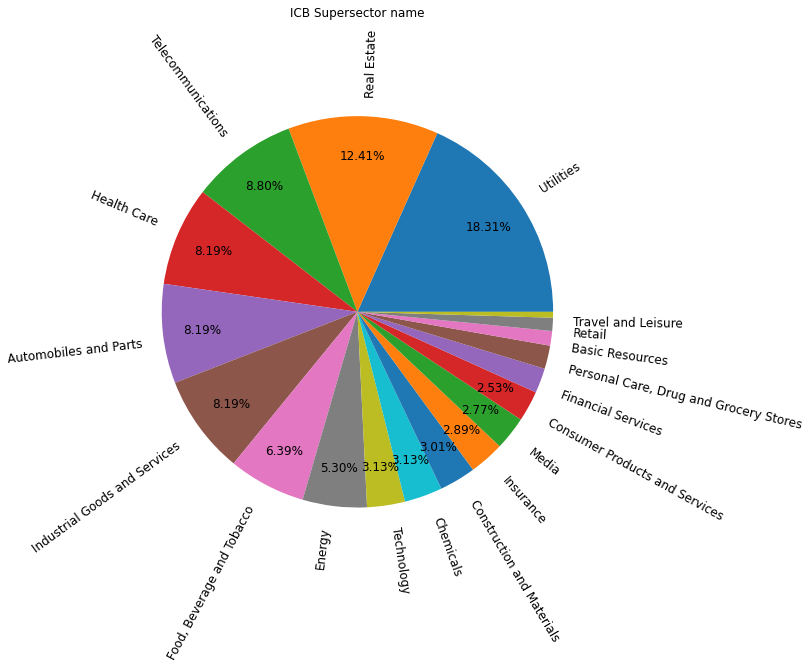

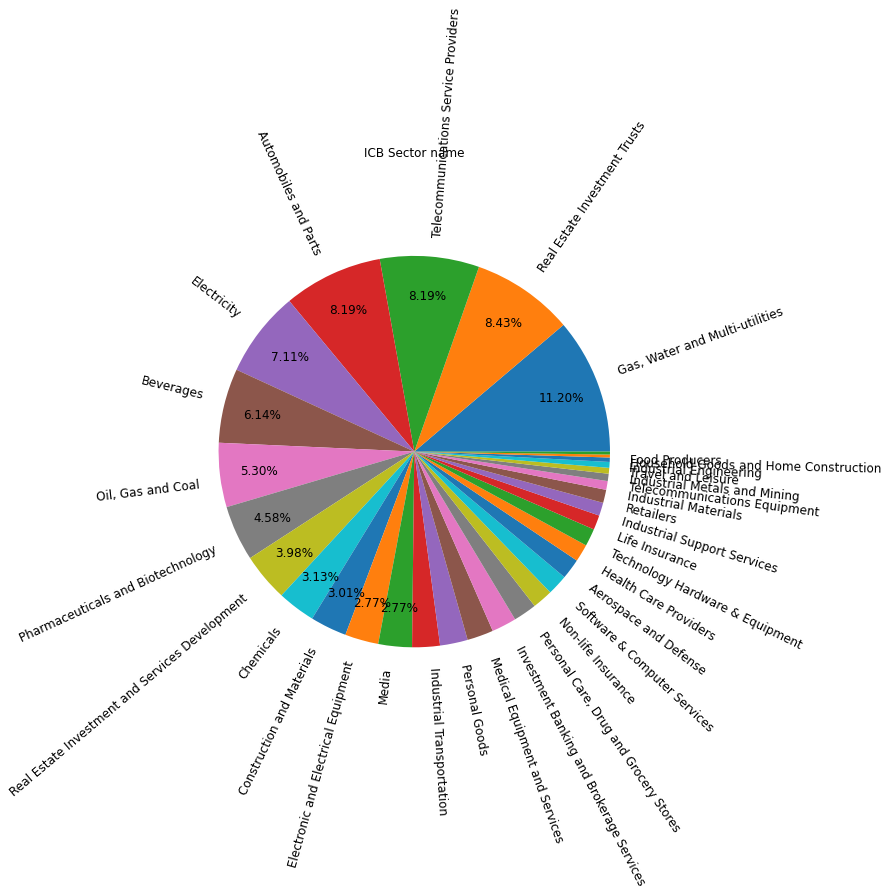

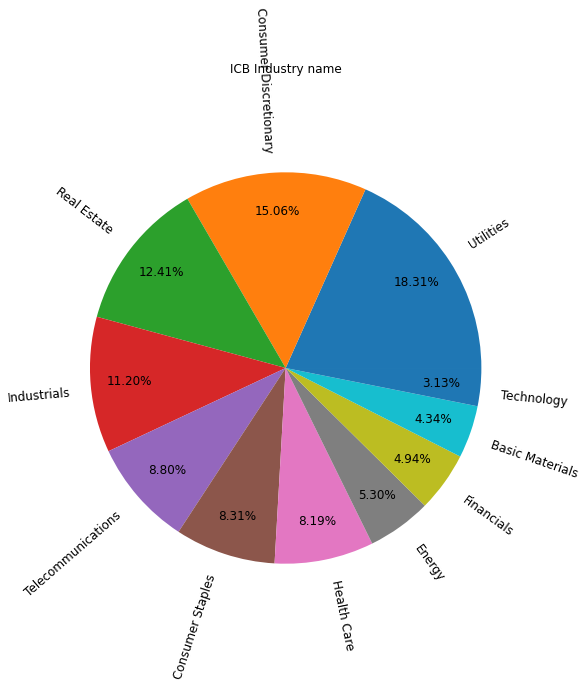

In [11]:
import matplotlib.pyplot as plt # TODO: add to requirements if used

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (pct > 2.4):
            return '{p:.2f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

def get_all_sectors(sector_type):
    sector_data['number']=1 # TODO: count them in a cleaner way
    sectors = sector_data[[sector_type, 'number']].groupby([sector_type]).sum()
    sectors = sectors.sort_values("number", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    return sectors
    
def make_pie_chart(column_name):
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(111)

    sectors = get_all_sectors(column_name)
    
    sectors.plot(kind='pie', y='number', ax=ax, autopct=make_autopct(sectors['number']), fontsize=12, legend=False, rotatelabels=True, pctdistance=0.8)
    plt.axis("off")
    plt.title(column_name+"\n\n\n")

make_pie_chart('ICB Supersector name')
make_pie_chart('ICB Sector name')
make_pie_chart('ICB Industry name')

## Which industries and sectors are green?

TODO: automate this process

A sector is considered green if it is in the list of "Green economy sectors" by Igor Mishevski.
https://medium.com/@mishevski/green-economy-sectors-ceecabeec7f0

In [12]:
industries = get_all_sectors('ICB Industry name')
super_sectors = get_all_sectors('ICB Supersector name')
sectors = get_all_sectors('ICB Sector name')

In [13]:
list_of_green_sectors = ["Real Estate", "Energy", "Oil, Gas and Coal"] # Buildings, Energy supply, ... TODO: update list

In [14]:
industries["green"]=0
super_sectors["green"]=0
sectors["green"]=0
for i in range(0, len(industries.index)):
    if industries.index[i] in list_of_green_sectors:
        industries["green"][i]=1
    if super_sectors.index[i] in list_of_green_sectors:
        super_sectors["green"][i]=1
    if sectors.index[i] in list_of_green_sectors:
        sectors["green"][i]=1
print(industries)
print(super_sectors)
print(sectors)

                        number  green
ICB Industry name                    
Utilities                  152      0
Consumer Discretionary     125      0
Real Estate                103      1
Industrials                 93      0
Telecommunications          73      0
Consumer Staples            69      0
Health Care                 68      0
Energy                      44      1
Financials                  41      0
Basic Materials             36      0
Technology                  26      0
                                        number  green
ICB Supersector name                                 
Utilities                                  152      0
Real Estate                                103      1
Telecommunications                          73      0
Health Care                                 68      0
Automobiles and Parts                       68      0
Industrial Goods and Services               68      0
Food, Beverage and Tobacco                  53      0
Energy              

In [15]:
 def show_table(column_names, row_names, content):
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    table = ax.table( 
        cellText = content,  
        rowLabels = row_names,  
        colLabels = column_names, 
        rowColours =["c"] * len(row_names),  
        colColours =["c"] * len(column_names), 
        cellLoc ='center',  
        loc ='upper left')         

    ax.set_title('Percentage of industries or sectors that is green', 
                 fontweight ="bold") 

    plt.show() 

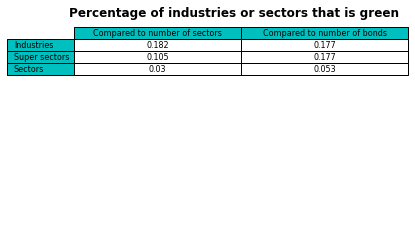

In [16]:
# Calculate the percentage of represented industries considered green
percentage_industries_green = industries["green"].sum()/len(industries.index)
percentage_super_sectors_green = super_sectors["green"].sum()/len(super_sectors.index)
percentage_sectors_green = sectors["green"].sum()/len(sectors.index)

# Calculate the percentage of represented bonds in green industries
percentage_bonds_green_industries = (industries["green"]*industries["number"]).sum()/industries["number"].sum()
percentage_bonds_green_super_sectors = (super_sectors["green"]*super_sectors["number"]).sum()/super_sectors["number"].sum()
percentage_bonds_green_sectors = (sectors["green"]*sectors["number"]).sum()/sectors["number"].sum()

show_table(["Compared to number of sectors", "Compared to number of bonds"], ["Industries", "Super sectors", "Sectors"],
           [[percentage_industries_green.round(3), percentage_bonds_green_industries.round(3)],
            [percentage_super_sectors_green.round(3), percentage_bonds_green_super_sectors.round(3)],
            [percentage_sectors_green.round(3), percentage_bonds_green_sectors.round(3)]])

# Environmental Analysis

## CO2 Data/Graphs

### Spaghetti plot CO$_2$

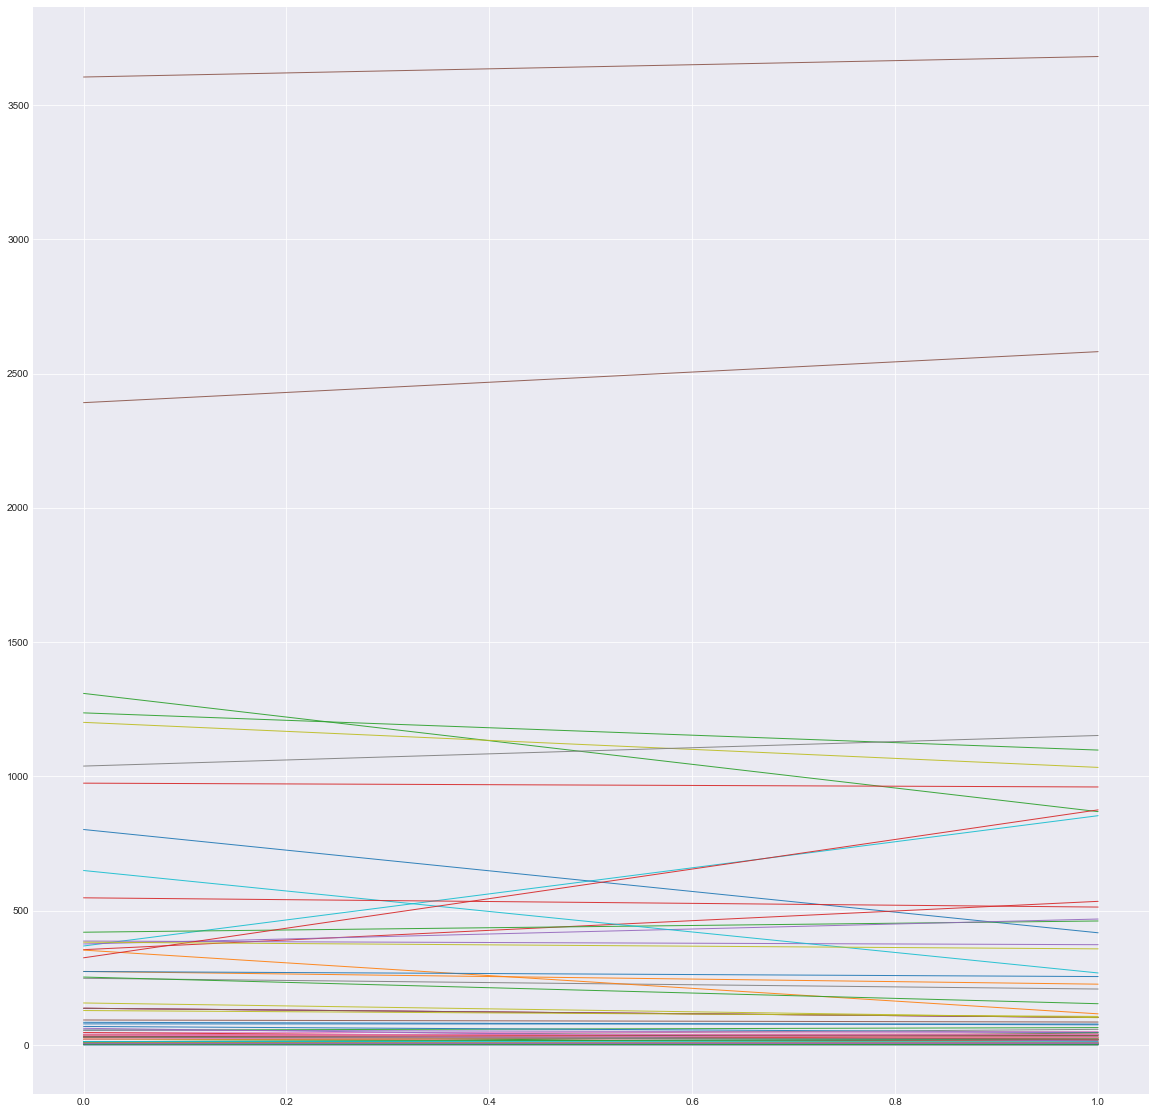

In [17]:
co2_data = eikon_data_complete[["ISSUER", "CO2", "CO2_1"]] #compnay name and CO2 subset 
company_co2_data = co2_data.drop_duplicates(subset= ["ISSUER"]) #Unique company name subset 
company_co2_data = company_co2_data[(company_co2_data.CO2 != '0') & (company_co2_data.CO2_1 != '0')] #not null value for CO2
company_co2_data = company_co2_data.reset_index() #resets index
company_co2_data = company_co2_data.drop(columns=["index"]) #removes extra column
company_co2_data = company_co2_data.replace(to_replace = '[,]', value ='.', regex=True) #making decimal points legible
company_co2_data['CO2'] =company_co2_data['CO2'].astype(float) #converting numbers to floats 
company_co2_data['CO2_1'] =company_co2_data['CO2_1'].astype(float)

#overall slope increase or decrease 
slopes = company_co2_data['CO2_1'] - company_co2_data['CO2']
slopes.sum() #shows an overall decrease in total emissions **Could cluster by sector. Hard to do anything else with 2 data points*


#making data easier to graph 
co2graph_data = company_co2_data[["CO2", "CO2_1"]]
co2graph_data = co2graph_data.transpose()
co2graph_data.insert(0, "x", [0, 1], True)


plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

#spaghetti plot of CO2 emissions 
plt.figure(figsize=(20,20))
for column in co2graph_data.drop(columns=["x"], axis=1):
    plt.plot(co2graph_data["x"], co2graph_data[column], marker='', linewidth=1, alpha=0.9)
    
plt.show()



### Histogram change in CO$_2$

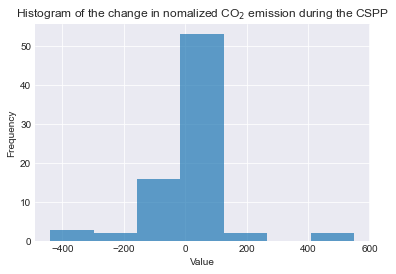

In [18]:
plt.hist(x=slopes, bins=7,alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(r'Histogram of the change in nomalized CO$_2$ emission during the CSPP')
plt.show()

### emission of 2021 as a function of the emission in 2015

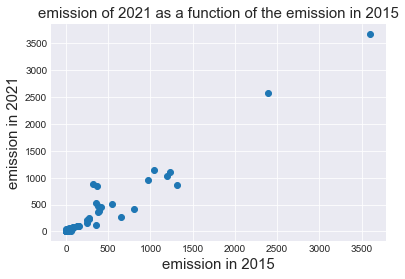

In [19]:
plt.plot(company_co2_data["CO2"],company_co2_data["CO2_1"],'o')
plt.title("emission of 2021 as a function of the emission in 2015", size=15)
plt.xlabel("emission in 2015", size=15)
plt.ylabel("emission in 2021",size=15)
plt.show()

Make a linear fit through for this graph (see github of course: data analytics > radient_descent)

In [20]:
from sklearn.linear_model import LinearRegression
# We will use the module Linear Regression of sklearn to perform the analysis
# Initialize the model
ols = LinearRegression()
# Fit the model to the data
ols.fit(company_co2_data["CO2"].values.reshape(-1, 1),company_co2_data["CO2_1"])

print('Fit is of the form:',np.round(ols.intercept_,3),'+',np.round(ols.coef_[0],3),'x')

Fit is of the form: -4.821 + 0.989 x


As the slope is slightly below one, we can conclude that in general, the normalized CO$_2$ emission decreases.

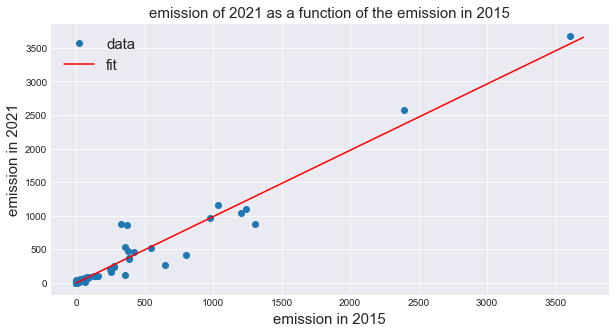

In [21]:
plt.figure(figsize=(10,5))

# plot of data
plt.plot(company_co2_data["CO2"],company_co2_data["CO2_1"],'o',label="data")

# plot of fit
x = np.arange(0,max((company_co2_data["CO2"])+100))
y = ols.intercept_ + ols.coef_[0]*x
plt.plot(x,y,'r-',label="fit")

# making a nice figure
plt.title("emission of 2021 as a function of the emission in 2015", size=15)
plt.xlabel("emission in 2015", size=15)
plt.ylabel("emission in 2021",size=15)
plt.legend(fontsize="15")

plt.show()

## ESG data/plots

Function for cleaning the ESG data

In [22]:
def cleaning_esg_data(df):
    column_names_esg_company_data = ["ISSUER", "ESG Score 2015", "ESG Score 2016", "ESG Score 2017", 
                                "ESG Score 2018", "ESG Score 2019", "ESG Score 2020", 
                                "ESG Score 2021"]
    #started cleaning data as above 
    esg_data = df[column_names_esg_company_data]
    esg_company_data = esg_data.drop_duplicates(subset= ["ISSUER"])
    esg_company_data = esg_company_data.replace(to_replace = '[,]', value ='.', regex=True)

    # replace zeros with nans, as these are easier to replace
    esg_company_data = esg_company_data.replace(to_replace = '0', value = np.nan) 

    # remove rows with no data for ESG score
    esg_company_data.dropna(axis=0, how='all', 
                            subset=column_names_esg_company_data[1:8], inplace=True)

    #converting all numbers to floats 
    for column_name in column_names_esg_company_data[1:8]:
        esg_company_data[column_name] = esg_company_data[column_name].astype(float)

    # interpolate data that is missing
    esg_company_data.iloc[:,1:] = esg_company_data.iloc[:,1:].interpolate(method='linear', axis=1, limit_direction='both',
                                                                          inplace=False)
    #TODO: If we want to keep this apart, we can make a new variable holding the filled in dataframe

    # reset the indexes
    esg_company_data = esg_company_data.reset_index()
    esg_company_data = esg_company_data.drop(columns=["index"])
    
    return esg_company_data

In [23]:
esg_company_data_holdings = cleaning_esg_data(eikon_data_complete)
esg_company_data_eligible = cleaning_esg_data(eligible_complete)

### Spaghetti plot ESG Scores

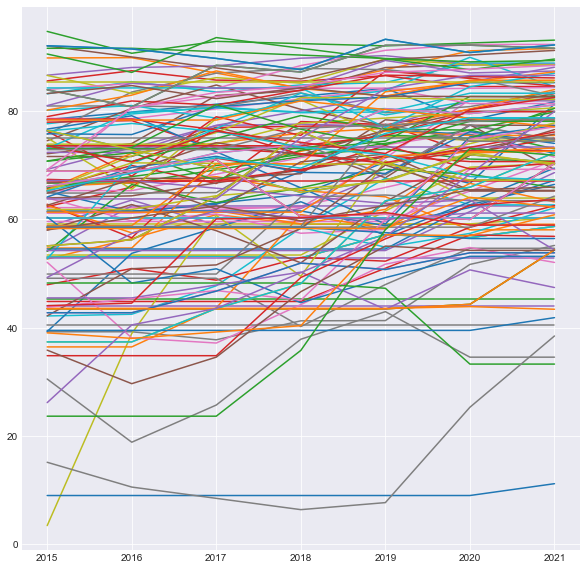

In [25]:
plt.figure(figsize=(10,10))
years = range(2015,2022)
for index,row in esg_company_data_holdings.iterrows():
    plt.plot(years,row[1:8])
plt.show()

### Some Descriptive Statistics

In [26]:
esg_company_data_holdings.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,62.156790,63.167049,64.976403,66.013230,68.266407,70.024616,71.151779
std,16.832183,16.563830,16.408036,15.688833,15.173085,14.653935,14.052443
min,3.485178,9.035207,8.511902,6.428276,7.725643,9.035207,11.218529
25%,52.976506,53.189321,54.312270,57.651837,58.623800,60.340022,62.485910
50%,63.953770,65.422763,66.917698,67.784729,70.247082,72.286777,72.441233
75%,73.817561,73.800401,76.984623,77.969904,79.110492,80.353174,82.051805
max,94.681897,91.568308,93.545750,92.430724,93.230124,92.542586,93.072831


In [27]:
esg_company_data_eligible.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,62.069953,63.995237,66.128372,67.472692,69.621426,70.497905,71.550933
std,19.055657,19.225019,17.977814,17.202404,16.394652,16.308647,15.747909
min,7.245926,14.533691,17.422135,18.792800,20.163466,25.318226,19.520247
25%,52.978833,55.010988,57.931346,59.222782,60.930691,64.037336,65.359909
50%,65.615280,67.266580,68.065178,69.602814,73.567484,73.959197,74.231511
75%,75.062302,78.451767,80.186580,81.979221,82.517499,82.742138,82.860713
max,91.992754,91.741976,91.769690,94.327360,93.230124,92.869364,92.869364


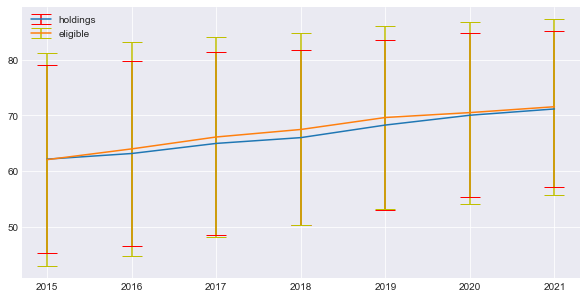

In [28]:
plt.figure(figsize=(10,5))

years = range(2015,2022)

mean_holdings = esg_company_data_holdings.mean().values
error_holdings = esg_company_data_holdings.std().values

mean_eligible = esg_company_data_eligible.mean().values
error_eligible = esg_company_data_eligible.std().values

plt.errorbar(years, mean_holdings, yerr=error_holdings, ecolor='r', capsize=10, label="holdings")

plt.errorbar(years, mean_eligible, yerr=error_eligible, ecolor='y', capsize=10, label="eligible")

plt.legend()

plt.show()

In this figure, we can clearly see that the average ESG-score of the companies increases.

<AxesSubplot:>

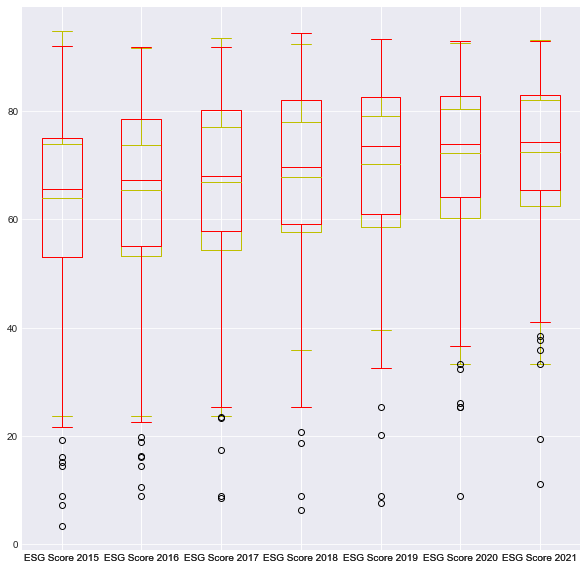

In [29]:
esg_company_data_holdings.iloc[:,1:].boxplot(figsize=(10,10),color='y')
esg_company_data_eligible.iloc[:,1:].boxplot(figsize=(10,10),color='r')

### ESG evolution of each company

fit the evolution of each company

In [30]:
from sklearn.linear_model import LinearRegression

def linReg_esg_company_data(esg_company_data):
    list_of_coef = []
    list_of_intercepts = []
    years = np.arange(0,7)
    # We will use the module Linear Regression of sklearn to perform the analysis
    # Initialize the model
    ols = LinearRegression()
    # Fit the model to the data
    for index,row in esg_company_data.iterrows():
        resultOfFit = ols.fit(years.reshape(-1, 1),row[1:8])
        list_of_coef.append(resultOfFit.coef_[0])
        list_of_intercepts.append(resultOfFit.intercept_)
    return list_of_coef,list_of_intercepts

list_of_coef_holdings, list_of_intercepts_holdings = linReg_esg_company_data(esg_company_data_holdings)
list_of_coef_eligible, list_of_intercepts_eligible = linReg_esg_company_data(esg_company_data_eligible)

Make a boxplot of the coefficients of these fits. This should give an indication about the general evolution (increase vs decrease).

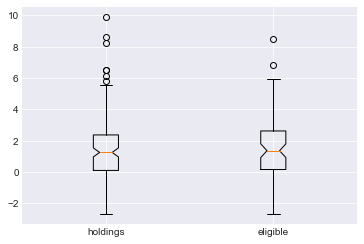

In [32]:
plt.figure()

plt.boxplot([list_of_coef_holdings, list_of_coef_eligible], "y")
plt.xticks(ticks=[1,2], labels=["holdings", "eligible"])

plt.show()

This figure shows us that only roughly 25% of companies have a negative slope, while the other 75% have an increasin ESG score.

Let us now try to find a relation between the initial ESG score and the most recent one. This can be done by plotting and calculating the covariance matrix.

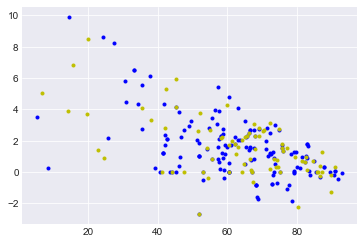

In [33]:
plt.figure()

plt.plot(list_of_intercepts_holdings,list_of_coef_holdings, 'b.')
plt.plot(list_of_intercepts_eligible,list_of_coef_eligible, 'y.')

plt.show()

In [34]:
print("holdings:\n", np.corrcoef(list_of_coef_holdings, list_of_intercepts_holdings),
      "\n eligible:\n", np.corrcoef(list_of_coef_eligible, list_of_intercepts_eligible))

holdings:
 [[ 1.         -0.54811866]
 [-0.54811866  1.        ]] 
 eligible:
 [[ 1.         -0.58874652]
 [-0.58874652  1.        ]]


There seems to be some negative correlation ==> lower initial value, faster increase in ESG score.